In [1]:
from cellrank.datasets import bone_marrow
import matplotlib.pyplot as plt

import project

In [2]:
adata = bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Velocity estimation using scvelo

In [3]:
project.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

project.pp.pca(adata)
# project.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
# project.pp.moments(adata, n_pcs=None, n_neighbors=None)

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'n_counts'
    var: 'palantir', 'means', 'variances', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types', 'pca'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

In [4]:
import scanpy as sc
import scvelo as scv
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
project.tl.recover_dynamics(adata, n_jobs=-1)
project.tl.velocity(adata, mode="dynamical")
project.tl.latent_time(adata)

recovering dynamics (using 22/22 cores)


  0%|          | 0/479 [00:00<?, ?gene/s]

    finished (0:01:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/22 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


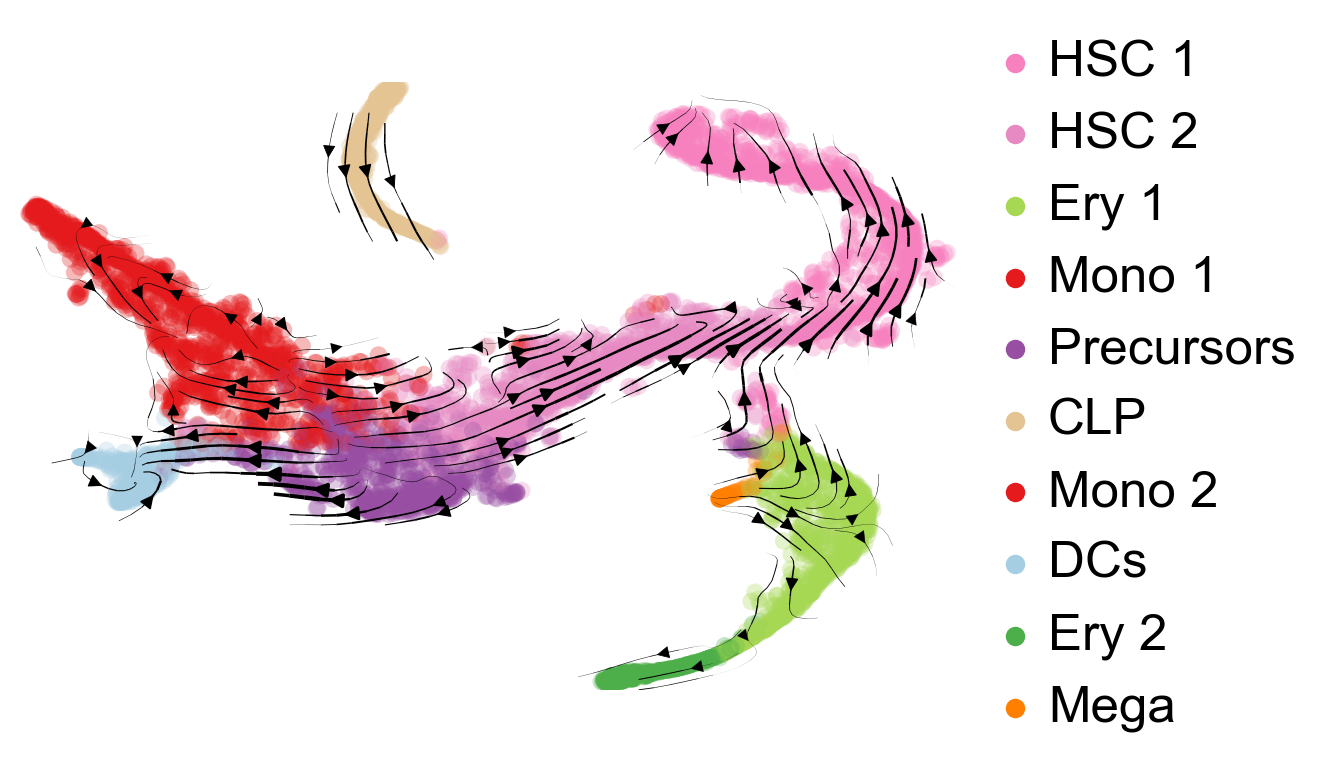

In [6]:
fig_kwargs = {"color": ["clusters"], "legend_loc": "right", "dpi": 100, "title": ""}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
project.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [22]:
# genes = ["ANGPT1", "RBPMS"]
genes = adata.var["fit_likelihood"].sort_values(ascending=False)[:2].index.to_list()

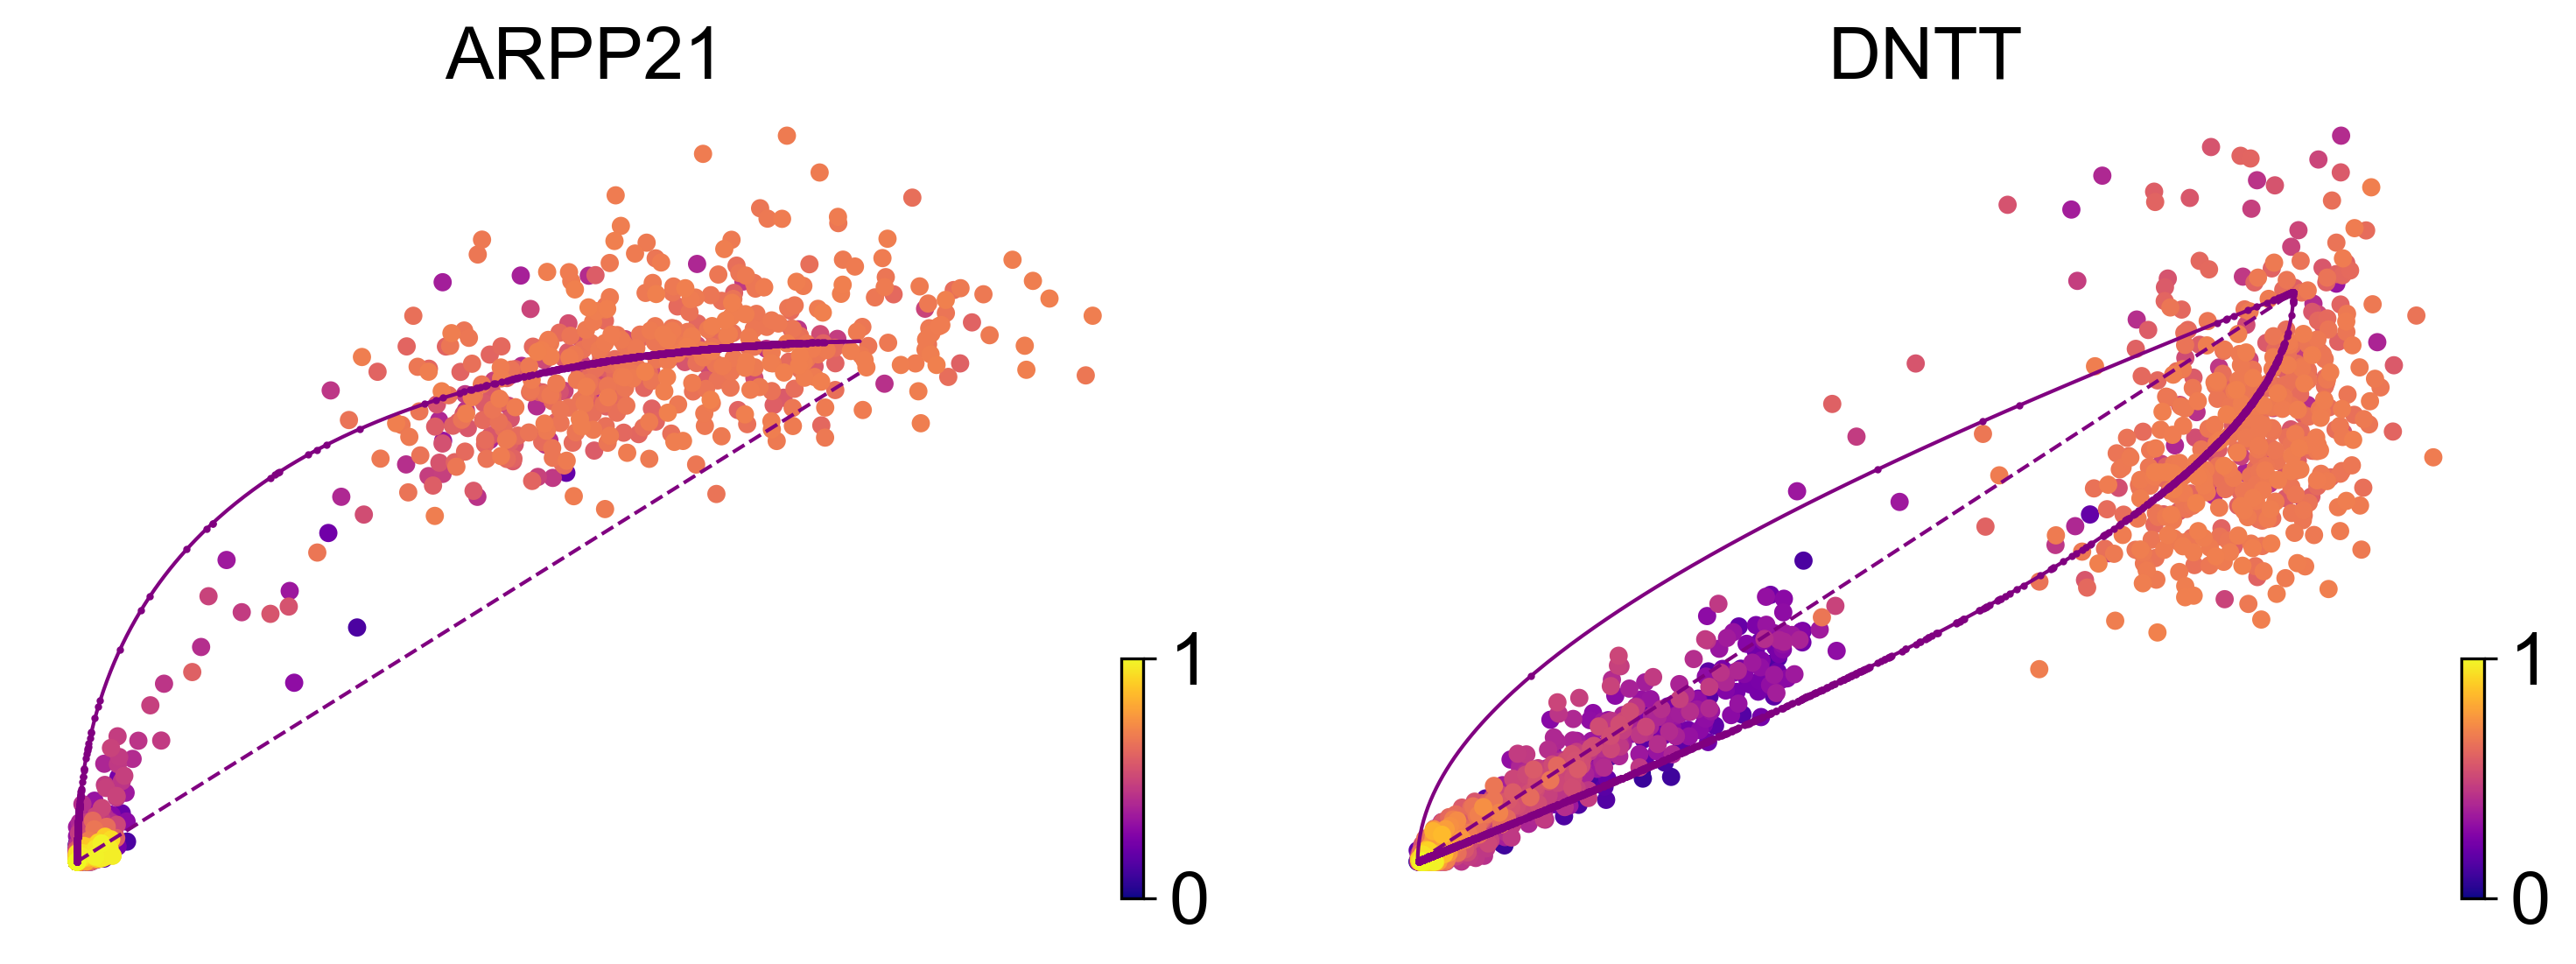

In [23]:
fig_kwargs = {
    "basis": genes,
    "color": "palantir_pseudotime",
    "color_map": "plasma",
    "frameon": False,
    "s": 100,
    "dpi": 150,
}
project.pl.scatter(adata, **fig_kwargs)

high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [24]:
indices, _ = project.gv.adj_to_knn(adata.obsp["connectivities"])
adata.uns["neighbors"]["indices"] = indices

In [10]:
project.gv.mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

calculating manifold-consistent scores in 22 cpu(s): 100%|██████████| 479/479 [00:31<00:00, 15.09it/s]


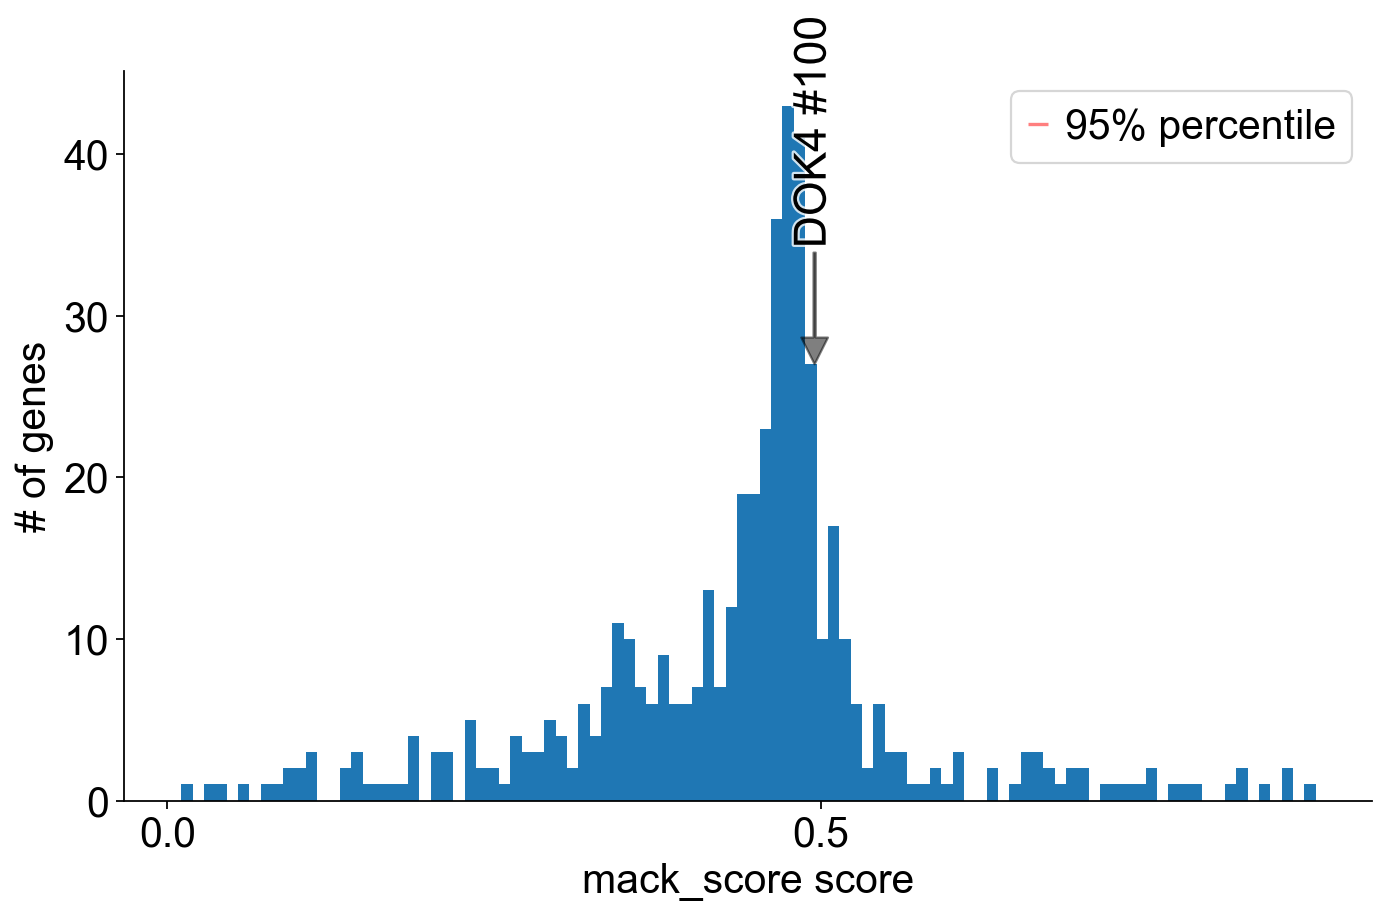

In [11]:
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = project.pl.gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

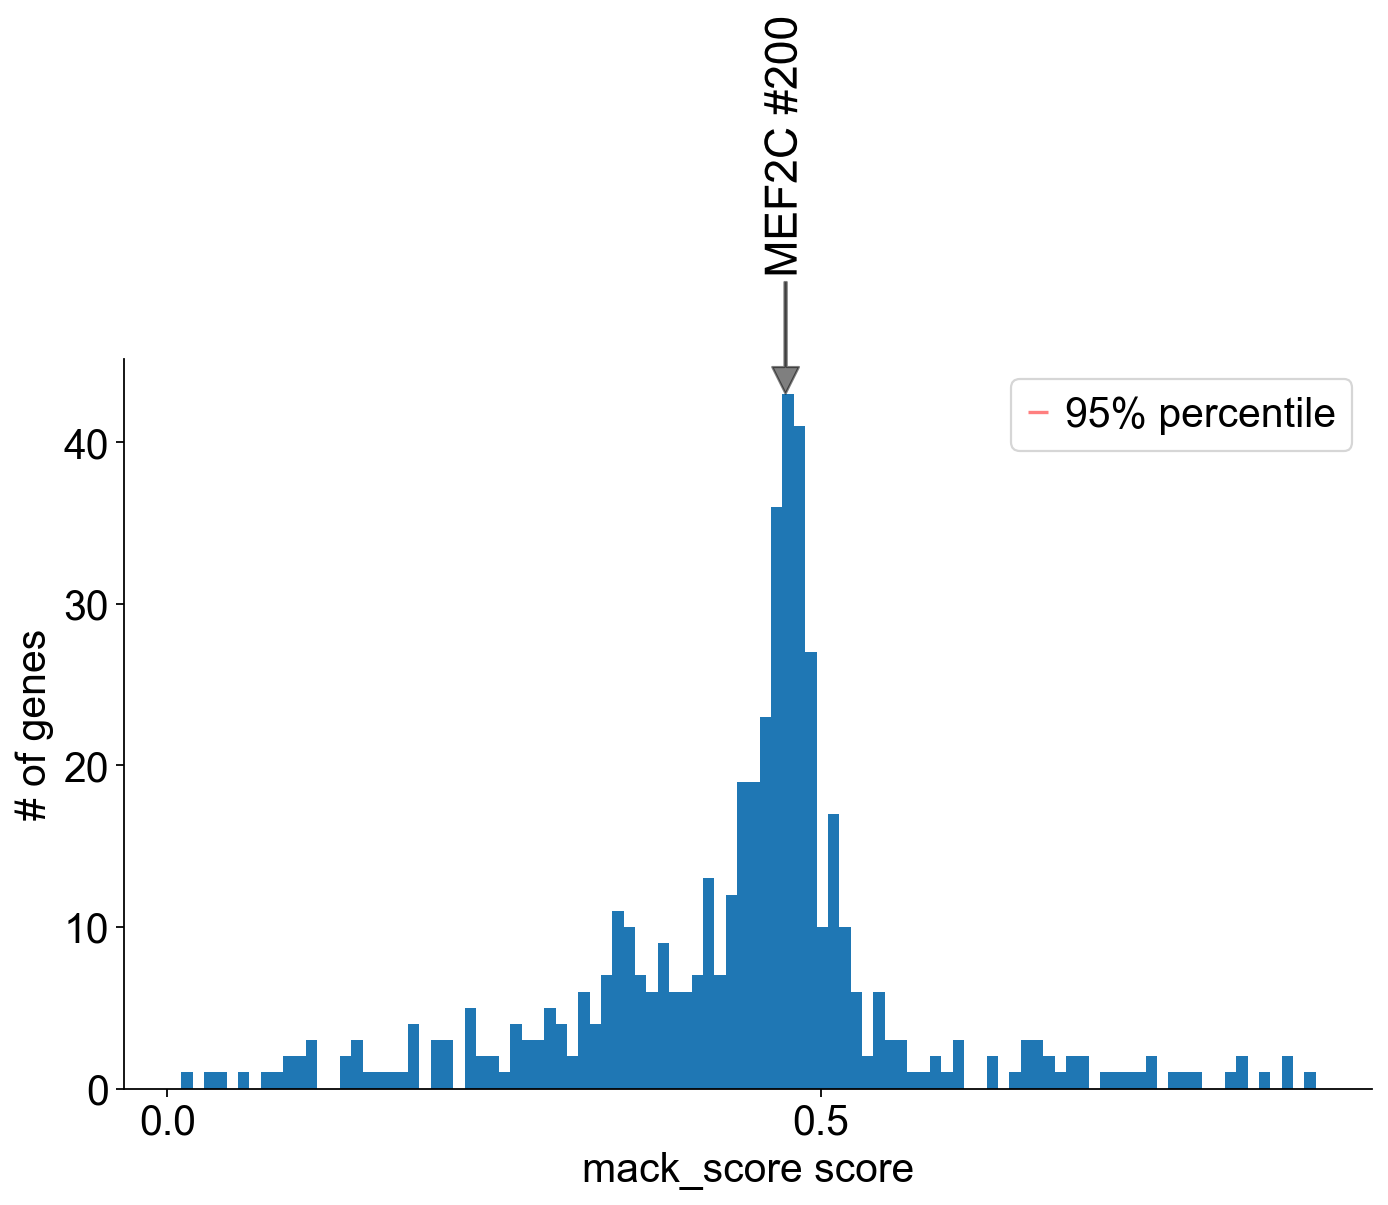

In [12]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = project.pl.gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|██████████| 5780/5780 [00:17<00:00, 339.20it/s]
e:\codes\cmu\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


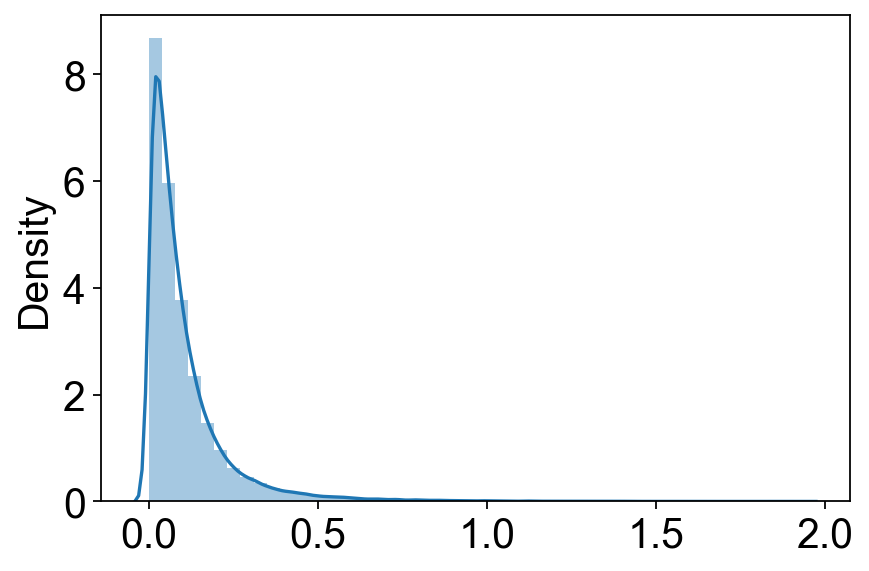

In [13]:
gv = project.gv.GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [14]:
adata.layers["velocity_gvs"] = gv.project_velocity(adata.layers["Ms"])
adata.layers["velocity_gvu"] = gv.project_velocity(adata.layers["Mu"])
adata.obsm["gv_pca"] = gv.project_velocity(adata.obsm["X_pca"])
adata.obsm["gv_tsne"] = gv.project_velocity(adata.obsm["X_tsne"])

projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:04<00:00, 1303.01it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:04<00:00, 1300.38it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 7495.04it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 7731.66it/s]


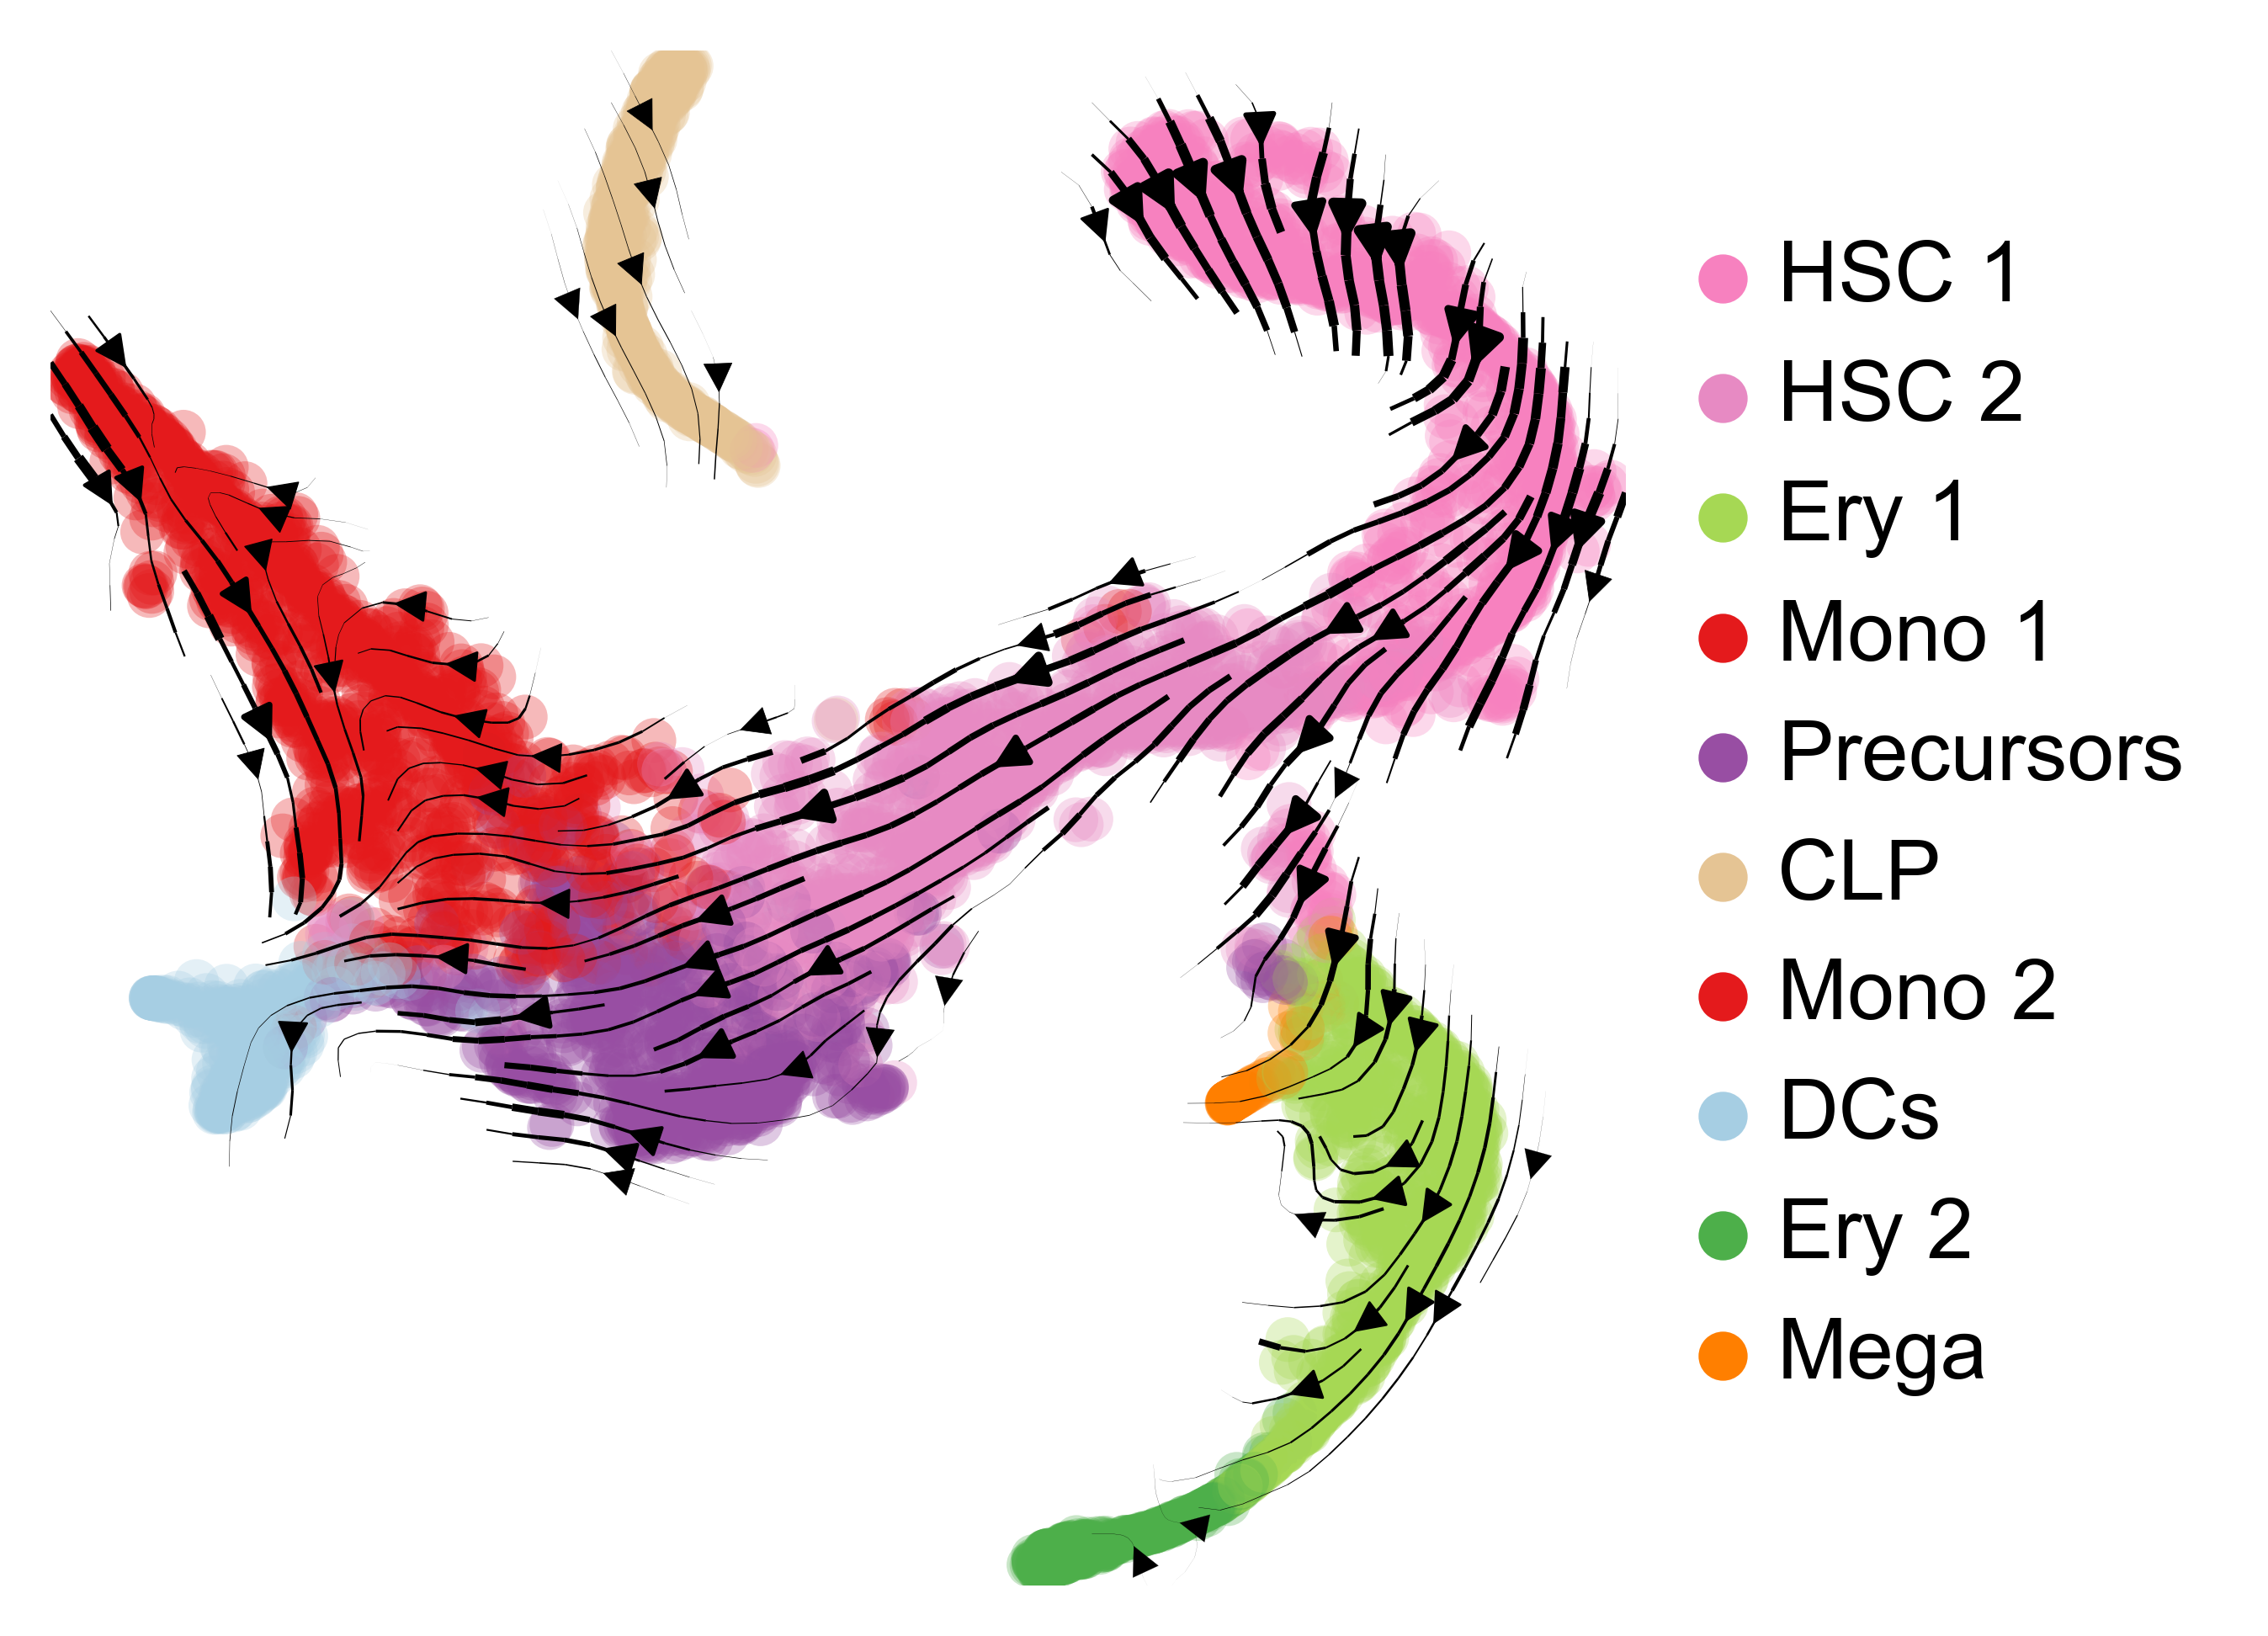

In [15]:
fig_kwargs = {
    "color": ["clusters"],
    "X": adata.obsm["X_tsne"],
    "V": adata.obsm["gv_tsne"],
    "legend_loc": "right",
    "dpi": 300,
    "title": "",
    "legend_fontsize": 12,
    "figsize": (4, 4),
}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
project.pl.velocity_embedding_stream(adata, **fig_kwargs)

Plotting velocity in phase diagram: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


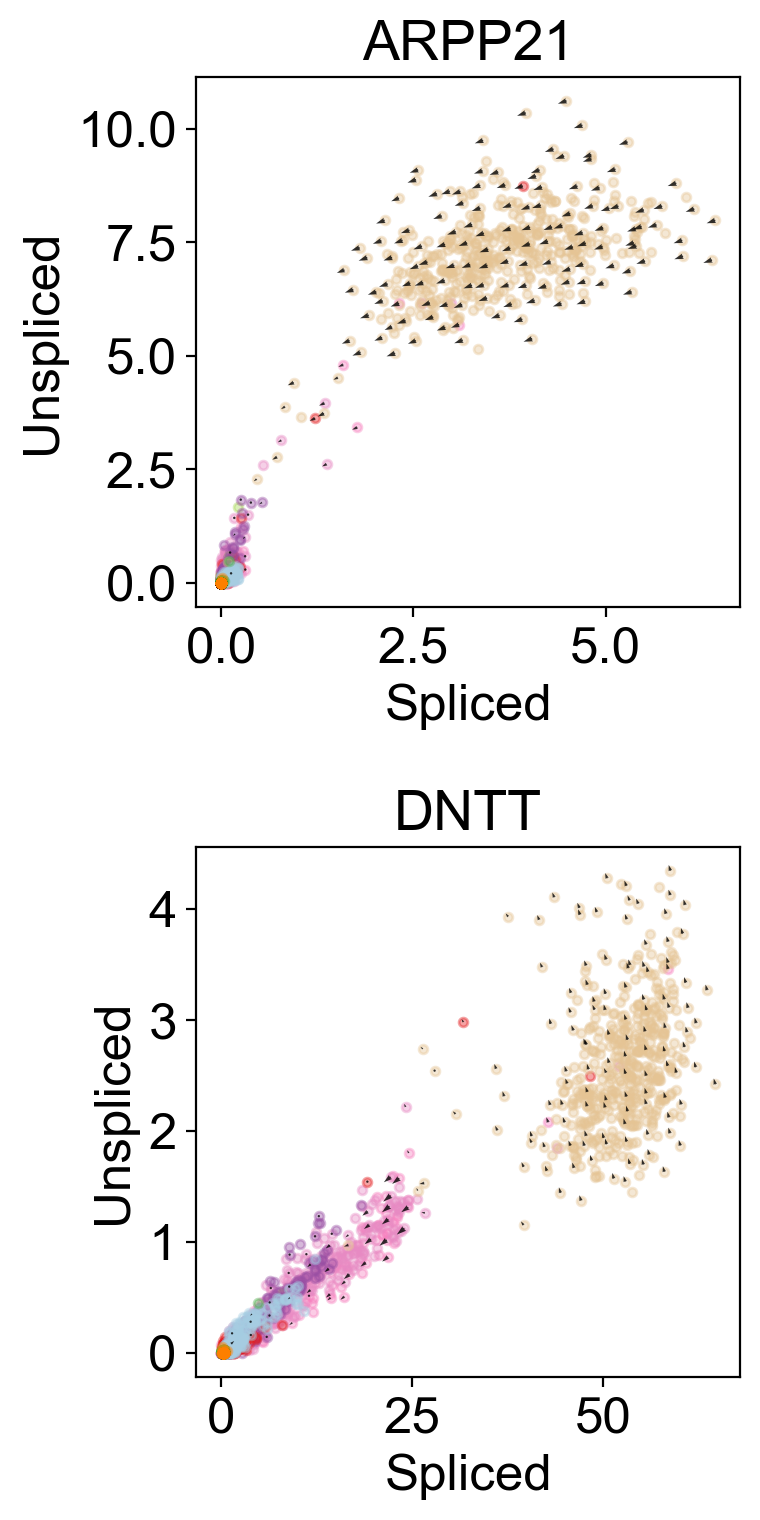

In [25]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity_gvs",
    "vu_layer": "velocity_gvu",
    "pointsize": 10,
    "ncols": 1,
    "scale": 3,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = project.pl.plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv100_phase.pdf', dpi=300, transparent=True)
plt.show()

Plotting velocity in phase diagram: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


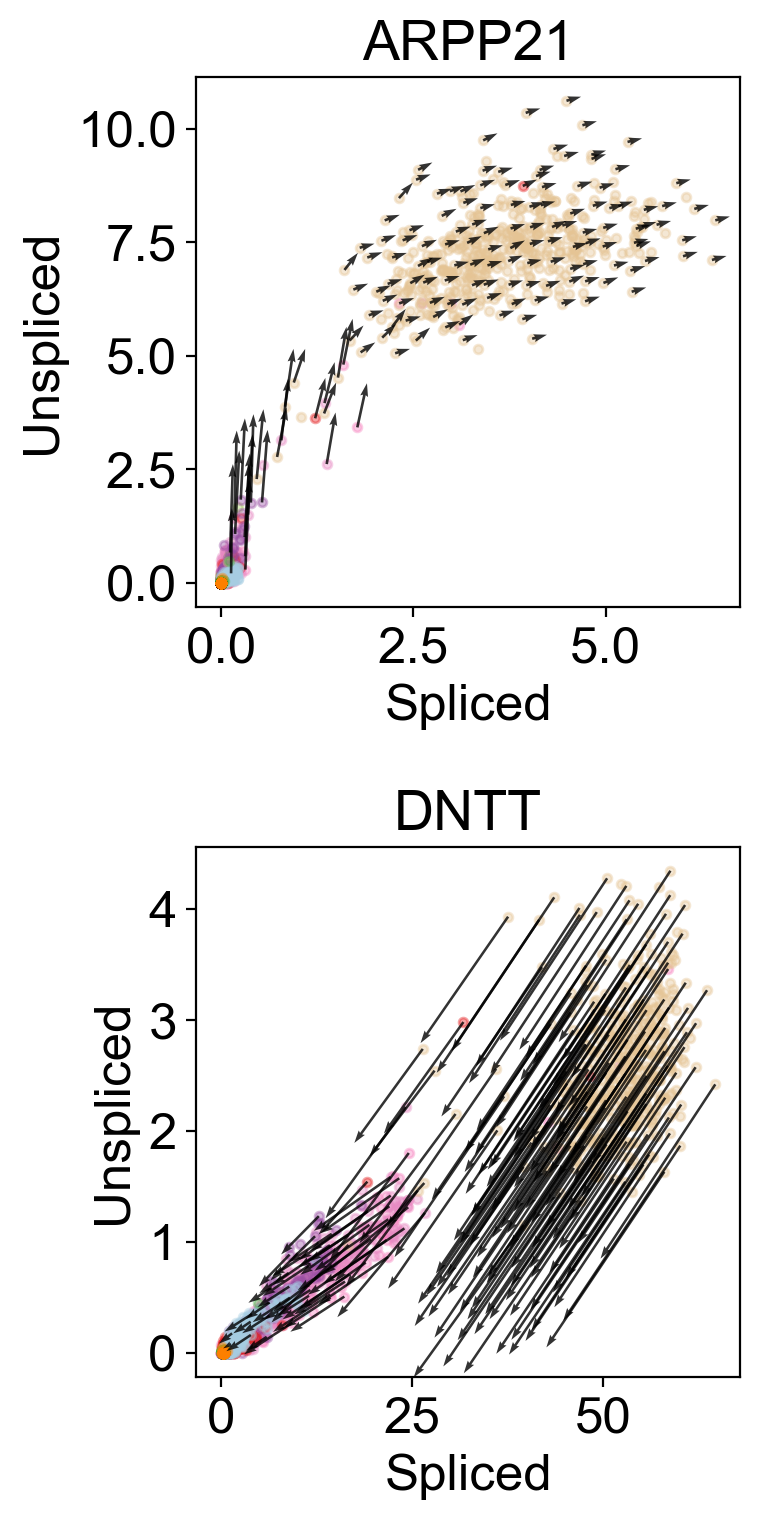

In [26]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity",
    "vu_layer": "velocity_u",
    "pointsize": 10,
    "ncols": 1,
    "scale": 1,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = project.pl.plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_hspc/genes_phase_velo.pdf', dpi=300, transparent=True)
plt.show()